# Hotel Booking Demand Analysis, Cancelation & Stay Period Prediction

Notebook Writer: Muhamad Haziq Bin Fuad
<br>Email: hzqmhmd@gmail.com

### Importing Packages

In [139]:
# data extraction, manipulation, cleaning & feature engineering
import pandas as pd
import numpy as np
import missingno as msno
import math

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling & prediction
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from mlxtend.regressor import StackingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

# model performance evaluator
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, mutual_info_score, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_auc_score, roc_curve, mean_squared_error

In [140]:
# importing the raw dataset downloaded from the powerpoint file provided (hotel_bookings.csv) and assign it to dataframe variable.

df = pd.read_csv("hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Since there is no definition provided for each feature, we will define it for this analysis.

<br><b>hotel</b> = Type of hotel i.e. Resort Hotel, City Hotel
<br><b>is_canceled</b> = Status of booking cancellation i.e. 0 - No, 1 - Yes
<br><b>lead_time</b> = Time difference between booking date and guest arrival date
<br><b>arrival_date_year</b> = Year of guest arrival date i.e. 2015, 2016, 2017
<br><b>arrival_date_month</b> = Month of guest arrival date i.e. January, February, March
<br><b>arrival_date_week_number</b> = Week of guest arrival date i.e. 1st week, 2nd week 
<br><b>arrival_date_day_of_month</b> = Day of guest arrival date i.e. 1, 2, 3
<br><b>stays_in_weekend_nights</b> = Number of weekend nights (i.e. Saturday or Sunday) the guest stayed or booked at the hotel
<br><b>stays_in_week_nights</b> = Number of week nights (i.e Monday to Friday) the guest stayed or booked at the hotel
<br><b>adults</b> = Number of adult
<br><b>children</b> = Number of child
<br><b>babies</b> = Number of baby
<br><b>meal</b> = Type of meal booked for the stay i.e. BB - Bed & Breakfast, HB - Halfboard, FB - Fullboard, Undefined - Did not specify any meal or not opting for it, SC - Snacks & Complimentary
<br><b>country</b> = Origin country of guests
<br><b>market_segment</b> = Market segment designation
<br><b>distribution_channel</b> = Booking distribution channel
<br><b>is_repeated_guest</b> = Indication for guest that booked has came before this i.e. 0 - No, 1 - Yes
<br><b>previous_cancellations</b> = Number of previous bookings that were cancelled by the customer prior to the current booking
<br><b>previous_bookings_not_canceled</b> = Number of previous bookings not cancelled by the customer prior to the current booking
<br><b>reserved_room_type</b> = Code of room type booked by the guest
<br><b>assigned_room_type</b> = Code of room type that is assigned to the guest
<br><b>booking_changes</b> = Number of amendments made to the booking from the moment the booking was logged in the hotel system until the moment of check-in or cancellation
<br><b>deposit_type</b> = Indication on deposit made to secure the booking
<br><b>agent</b> = ID of the travel agency that made the booking
<br><b>company</b> = ID of the company or entity that made the booking
<br><b>days_in_waiting_list</b> = Number of days the booking was in the waiting list before it was confirmed to the customer
<br><b>customer_type</b> = Type of booking i.e. Contract - when the booking has an allotment or other type of contract associated to it, Group – when the booking is associated to a group, Transient – when the booking is not part of a group or contract, and is not associated to other transient booking, Transient-party – when the booking is transient, but is associated to at least other transient booking
<br><b>adr</b> = average daily rate or price per night for hotel room
<br><b>required_car_parking_spaces</b> = Number of car parking spaces required by the guest
<br><b>total_of_special_requests</b> = Number of special requests made by the customer
<br><b>reservation_status</b> = Latest status of the booking
<br><b>reservation_status_date</b> = Date of the latest status of the booking

### Data Cleaning

In [141]:
#checking for missing values in the dataset

missing_number = df.isnull().sum().sort_values(ascending=False)
missing_percent = round(df.isnull().sum() / df.isnull().count() * 100, 2).sort_values(ascending=False)
missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])

missing_values

,Missing_Number,Missing_Percent
company,112593,94.31
agent,16340,13.69
country,488,0.41
children,4,0.00
reserved_room_type,0,0.00
assigned_room_type,0,0.00
booking_changes,0,0.00
deposit_type,0,0.00
hotel,0,0.00
previous_cancellations,0,0.00


Seems like there are missing values for 'company' (94%), 'agent' (13%), 'country' (0.4%) & 'children features' (less than 0.00%, 4 missing datapoints).

<AxesSubplot:>

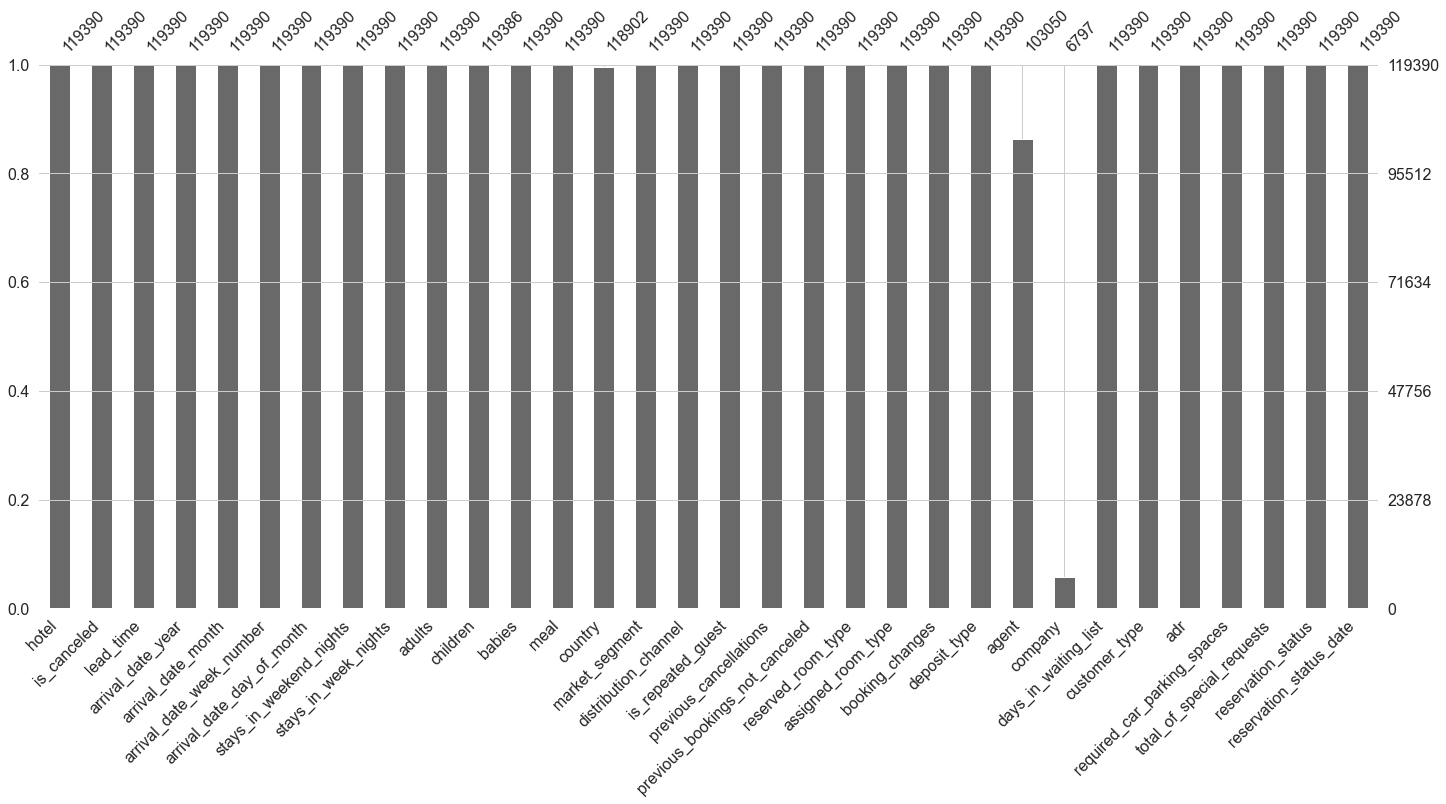

In [142]:
msno.bar(df)

<AxesSubplot:>

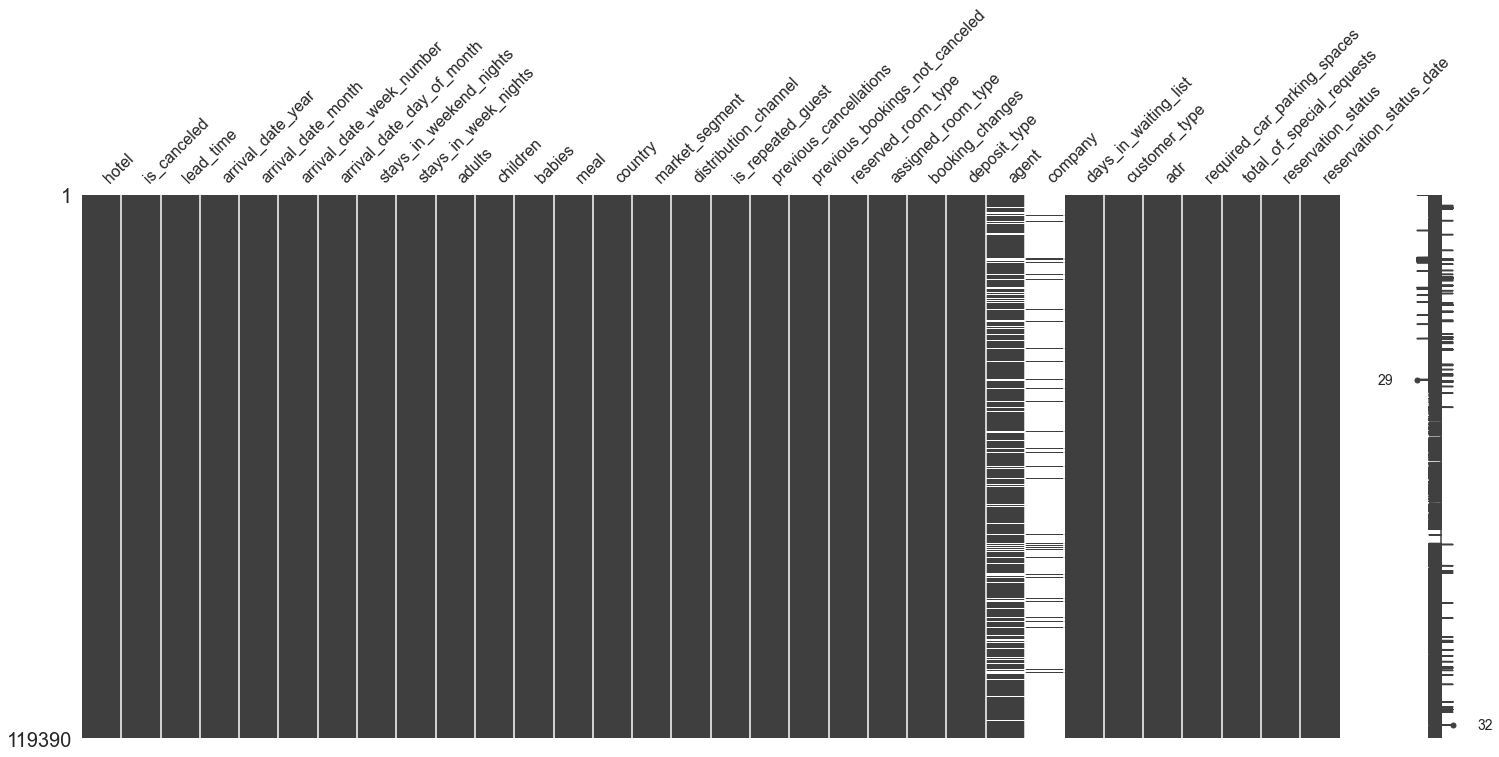

In [143]:
msno.matrix(df)

In [144]:
# missing datapoints for 'children' feature

df['children'][df.children.isnull() == True]

40600   NaN
40667   NaN
40679   NaN
41160   NaN
Name: children, dtype: float64

Since there is only 4 rows of missing data within the 'children' column, we will just remove it because the number is very tiny.

In [145]:
df.dropna(subset='children', axis=0, inplace=True)

In [146]:
# missing datapoints for 'country' feature

df['country'][df.country.isnull() == True]

30        NaN
4127      NaN
7092      NaN
7860      NaN
8779      NaN
         ... 
65908     NaN
65909     NaN
65910     NaN
80830     NaN
101488    NaN
Name: country, Length: 488, dtype: object

In [147]:
# missing datapoints for 'agent' feature

df['agent'][df.agent.isnull() == True]

0        NaN
1        NaN
2        NaN
6        NaN
18       NaN
          ..
119124   NaN
119151   NaN
119166   NaN
119215   NaN
119248   NaN
Name: agent, Length: 16338, dtype: float64

Replace null values in 'country' column with Unknown. Even though the percentage of missing rows is only 0.4%, we will try our best to preserve our data to avoid dropping any significant data points. If 'agent' is null, we assume that that the customers made the booking without using agent or directly with the hotel staffs.
Same goes to the 'company', if there is null values in the 'company' column, we will assume that the entity is likely not a company that made the booking.

In [148]:
# replace null values with the following value as assumption for 'country', 'agent' & 'company'

df = df.fillna({'country' : 'Unknown', 'agent' : 0, 'company' : 0})

There are datapoints with no number of guests (i.e. zero adults, children & babies). Since the number of rows are small, we will opt to filter out those rows.

In [149]:
# remove bookings data with zero number of guests/people

no_guest = df["adults"] + df["children"] + df["babies"] == 0
df = df[~no_guest]

In regards to the 'adr' feature, there are 1,810 rows that are zero and negative room price per night. It is not logic that booking fees or room price per night is free or negative. Since the number of datapoints are only 1,810 (1.5% from the total rows of the dataset), we will remove it.

In [150]:
# Price of room per night that are less than or equal to zero

df[df['adr'] <= 0].shape

(1811, 32)

In [151]:
# Percentage of price of room per night that are less than or equal to zero

round(df[df['adr'] == 0].shape[0] / df.shape[0] * 100, 2)

1.52

In [152]:
# filter out data that have less than or equal to zero price of room per night

zero_room_price = df['adr'] == 0
df = df[~zero_room_price]

In [153]:
print(f'After thorough data cleaning process, our final dataset is consist of {df.shape[0]} rows and {df.shape[1]} features.')

After thorough data cleaning process, our final dataset is consist of 117396 rows and 32 features.


### Data Understanding

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117396 entries, 2 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           117396 non-null  object 
 1   is_canceled                     117396 non-null  int64  
 2   lead_time                       117396 non-null  int64  
 3   arrival_date_year               117396 non-null  int64  
 4   arrival_date_month              117396 non-null  object 
 5   arrival_date_week_number        117396 non-null  int64  
 6   arrival_date_day_of_month       117396 non-null  int64  
 7   stays_in_weekend_nights         117396 non-null  int64  
 8   stays_in_week_nights            117396 non-null  int64  
 9   adults                          117396 non-null  int64  
 10  children                        117396 non-null  float64
 11  babies                          117396 non-null  int64  
 12  meal            

In [155]:
# analyzing numerical & categorical features by seperating them into 2 dataframe variables

numerical = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
categorical = list(df.select_dtypes(include=['object']).columns.values)

df[numerical].describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000,117396.000000
mean,0.374859,105.098615,2016.160287,27.135771,15.803051,0.936097,2.520452,1.861111,0.104535,0.007871,0.027871,0.086971,0.125294,0.215868,75.192690,10.549533,2.338615,103.543706,0.062626,0.570965
std,0.484089,106.913584,0.706585,13.575269,8.783421,0.994617,1.890007,0.481211,0.399744,0.097182,0.164605,0.848807,1.446185,0.630955,107.242723,53.553072,17.679568,49.192458,0.245537,0.791635
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,70.530000,0.000000,0.000000
50%,0.000000,71.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,162.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,4.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


We have 20 features with numerical values (i.e. int64, float64 datatypes). There are features with date, which will be preprocessed later on, if need be. Roughly, most of the features are measured in similar scales. There are categorical features, however it is identified as numerical datatypes. Will change to categorical features during the preprocessing part later on.

Identify imbalance target variable for modeling & prediction process

D:\Softwares\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



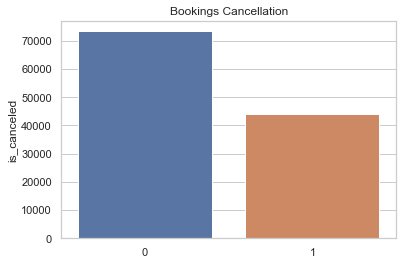

In [156]:
sns.barplot(df['is_canceled'].value_counts().index,df['is_canceled'].value_counts()).set_title('Bookings Cancellation')
plt.show()

In [157]:
y = df['is_canceled']
print(f'Percentage of bookings cancelled: % {round(y.value_counts(normalize=True)[1]*100,2)} --> ({y.value_counts()[1]} booking)\nPercentage of bookings proceeded: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} booking)')

Percentage of bookings cancelled: % 37.49 --> (44007 booking)
Percentage of bookings proceeded: % 62.51 --> (73389 booking)


The dataset is considered quite imbalanced due to its proportion of the target variable i.e. 60:40. Since, the imbalanced is not severe, we will attempt to proceed without conducting any oversampling and see how the model performs later on.

## Exploratory Data Analyasis (EDA)

1) Where do most of the hotel bookings come from?

In [158]:
country_data = pd.DataFrame(df.loc[df["is_canceled"] == 0]["country"].value_counts()) # Number of hotel bookings by guest's origin country
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index

# pie chart of Country of Hotel Guests
fig = px.pie(country_data, values = "Number of Guests", names = "country", title = "Country of Hotel Guests", template = "seaborn")
fig.update_traces(textposition="inside", textinfo="percent+label")
fig.show()

<IPython.core.display.Javascript object>

From the pie chart above, we can observe that most of the hotel guest are coming from Portugal, followed by UK, France and other European Countries.

2) How does the hotel room price varies across each month & year?

In [159]:
#Since we do not have booking date, we will only be using arrival_date and only for rooms that proceeded (i.e. not cancelled)
rooms = df[df['is_canceled'] == 0][['arrival_date_year', 'arrival_date_month', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights']]

# dictionary of month in integer
months = {'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5, 'June' : 6, 'July' : 7, 'August' : 8, 'September' : 9, 'October' : 10, 'November' : 11, 'December' : 12}

# function to change month from string to integer type
def change_month_str_to_int(month):
    return months[month]

rooms['month_num'] = rooms['arrival_date_month'].apply(change_month_str_to_int)
rooms = rooms.sort_values(by=['arrival_date_year', 'month_num'], ascending=True).reset_index(drop=True)

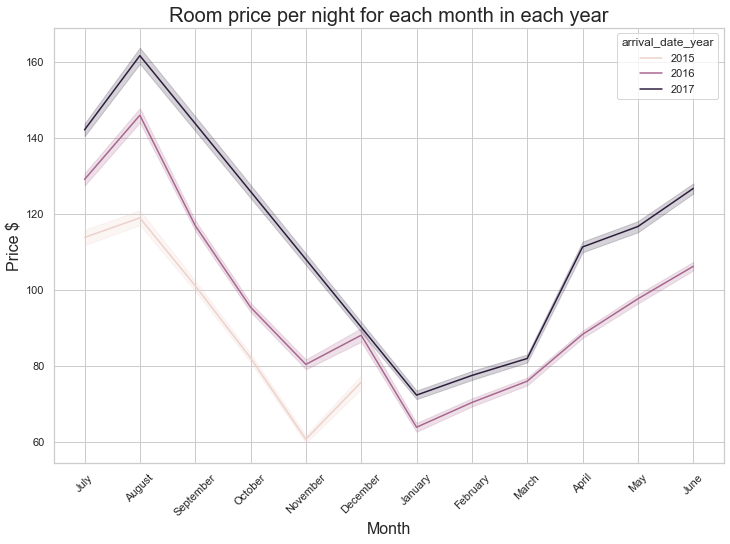

In [160]:
# barplot of room price across each month in each year
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.lineplot(x = "arrival_date_month", y = "adr", hue = "arrival_date_year", data = rooms, hue_order = ["2015", "2016", "2017"])
plt.title("Room price per night for each month in each year", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price $", fontsize=16)
plt.show()

- Price of room increasing from year-to-year
- August has the highest room price in each year whilst January is when the room price is the cheapest. It is advisable for guests to make bookings in January.
- Room price starts to increase starting from March until August

3) How long do guests planning to stay in the hotel?

In [161]:
period = df[['arrival_date_year', 'arrival_date_month', 'hotel', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies']]
period['total_nights'] = period['stays_in_weekend_nights'] + period['stays_in_week_nights'] #total number of nights of stay
period['total_people'] = period['adults'] + period['children'] + period['babies'] # total number of guests for a booking, including children & babies
period = period.groupby(['total_nights', 'hotel'])['total_people'].sum().reset_index()
period['total_people_percent'] = round(period['total_people'] / period['total_people'].sum() * 100, 2)

C:\Users\Haziq\AppData\Local\Temp/ipykernel_7596/1721168705.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Haziq\AppData\Local\Temp/ipykernel_7596/1721168705.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



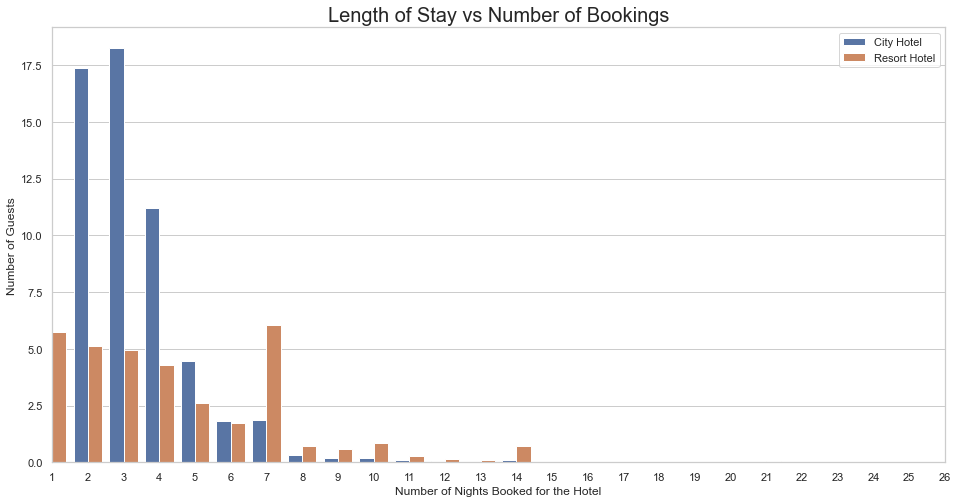

In [162]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "total_nights", y = "total_people_percent", hue = "hotel", data = period)
plt.title("Length of Stay vs Number of Bookings", fontsize=20)
plt.xlabel("Number of Nights Booked for the Hotel", fontsize=12)
plt.ylabel("Number of Guests", fontsize=12)
plt.legend(loc="upper right")
plt.xlim(0,25)
plt.show()

- Majority of bookings are made between 2 - 4 nights of stay
- Most people made hotel bookings at the city, instead of resort or outskirt of town

4) Which type of meal favoured by the guests?

In [163]:
# meals chosen by hotel guests by hotel types
meals = df[df['is_canceled'] == 0].groupby(['meal', 'hotel'])['arrival_date_month'].count().reset_index()
meals.rename(columns = {'arrival_date_month' : 'count'}, inplace = True)

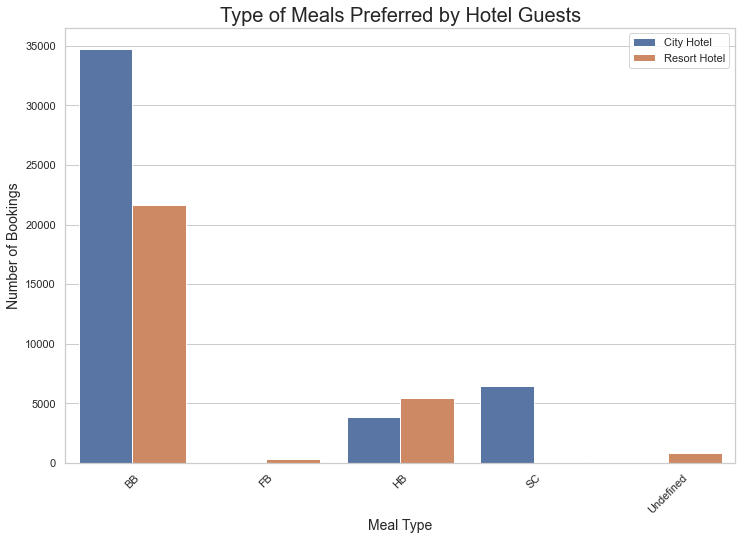

In [164]:
# bar chart plot of the preferable meals by hotel guests
plt.figure(figsize=(12, 8))
sns.barplot(x = "meal", y = "count" , hue = "hotel", data = meals)
plt.title("Type of Meals Preferred by Hotel Guests", fontsize=20)
plt.xlabel("Meal Type", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Bookings", fontsize=14)
plt.legend(loc="upper right")
plt.show()

- Majority of hotel bookings preferred Bed & Breakfast meal type when staying at City Hotel.
- However, bookings that preferred Half-Board meal type are mostly at the Resort Hotel.

5) Which market segments dominated the hotel bookings?

In [165]:
# number of bookings made (including cancelled) for each distribution channel
channel = df['distribution_channel'].value_counts()

# pie plot
fig = px.pie(channel, values = channel.values, names = channel.index, title = "Percentage of Bookings for each Distribution Channel", template = "seaborn")
fig.update_traces(textinfo = "percent+label")
fig.show()

<IPython.core.display.Javascript object>

6) How many bookings got cancelled in each month?

In [166]:
cancel = df[['is_canceled', 'arrival_date_month', 'hotel', 'customer_type']]
bookings = cancel.copy()

cancel = cancel.groupby(['arrival_date_month', 'hotel', 'customer_type'])['is_canceled'].sum().reset_index()
cancel.rename(columns = {'is_canceled' : 'Number of Cancellations'}, inplace = True)
bookings = bookings.groupby(['arrival_date_month', 'hotel', 'customer_type'])['is_canceled'].count().reset_index()
bookings.rename(columns = {'is_canceled' : 'Number of Bookings'}, inplace = True)
cancel = cancel.merge(bookings)
cancel['Percentage of Cancellations'] = round(cancel['Number of Cancellations'] / cancel['Number of Bookings'] * 100, 2)
cancel.rename(columns = {'arrival_date_month' : 'Month', 'hotel' : 'Hotel', 'customer_type' : 'Customer Type'}, inplace = True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
cancel["Month"] = pd.Categorical(cancel["Month"], categories=ordered_months, ordered=True)

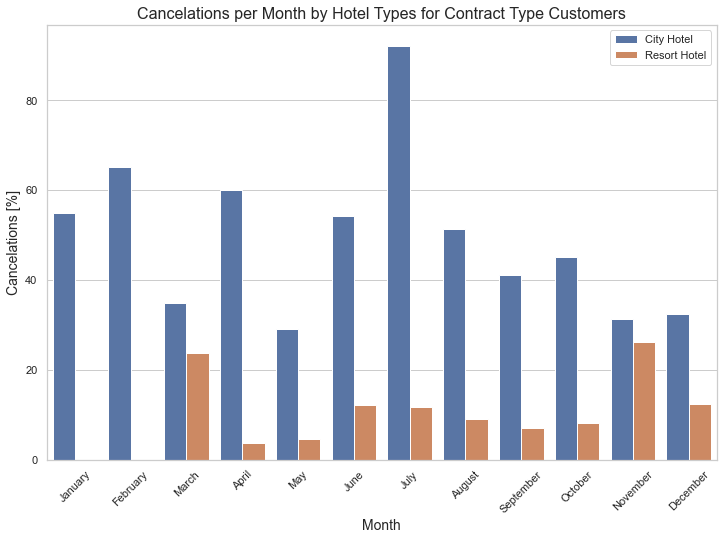

In [167]:
# bar plot of hotel bookings cancellation in each month for Contract Type Customers
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "Percentage of Cancellations" , hue = "Hotel", data = cancel[cancel['Customer Type'] == 'Contract'])
plt.title("Cancelations per Month by Hotel Types for Contract Type Customers", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=14)
plt.legend(loc="upper right")
plt.show()

- Most people cancel their bookings in the month of July for City Hotel type, whilst the lowest cancellations can be seen during the holiday season i.e. month of December
- This is acceptable as people wants to spend their holiday at the hotels that they have booked during the holiday season.

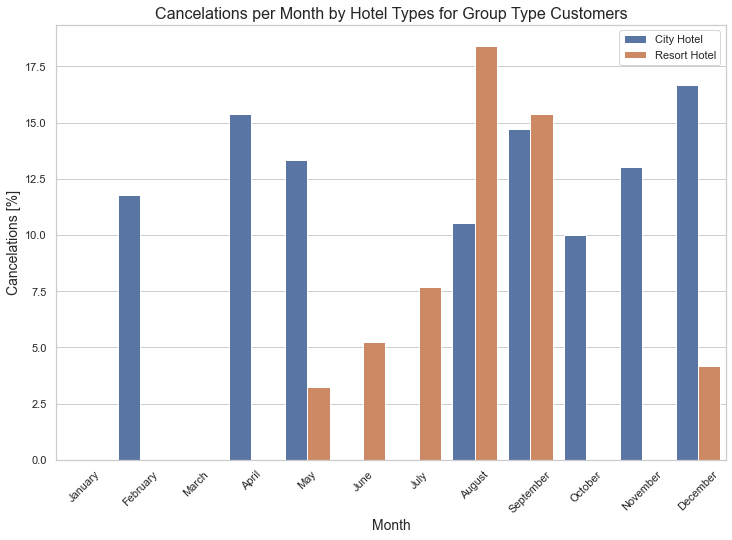

In [168]:
# bar plot of hotel bookings cancellation in each month for Group Type Customers
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "Percentage of Cancellations" , hue = "Hotel", data = cancel[cancel['Customer Type'] == 'Group'])
plt.title("Cancelations per Month by Hotel Types for Group Type Customers", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=14)
plt.legend(loc = "upper right")

plt.show()

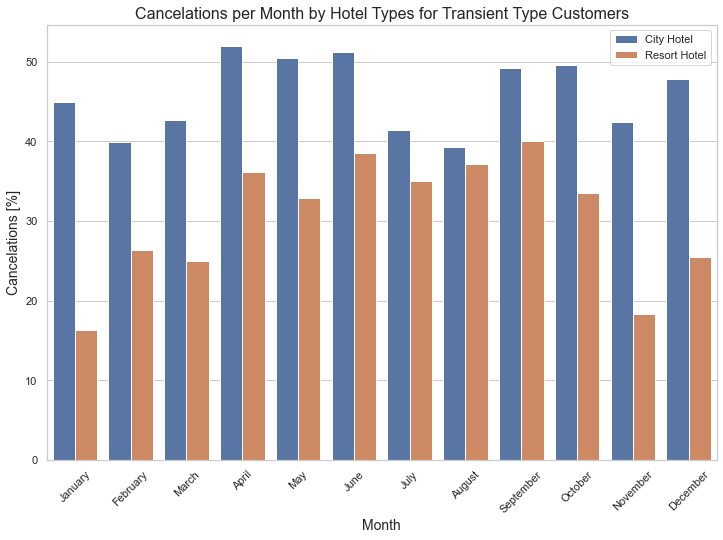

In [169]:
# bar plot of hotel bookings cancellation in each month for Transient Type Customers
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "Percentage of Cancellations" , hue = "Hotel", data = cancel[cancel['Customer Type'] == 'Transient'])
plt.title("Cancelations per Month by Hotel Types for Transient Type Customers", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=14)
plt.legend(loc="upper right")

plt.show()

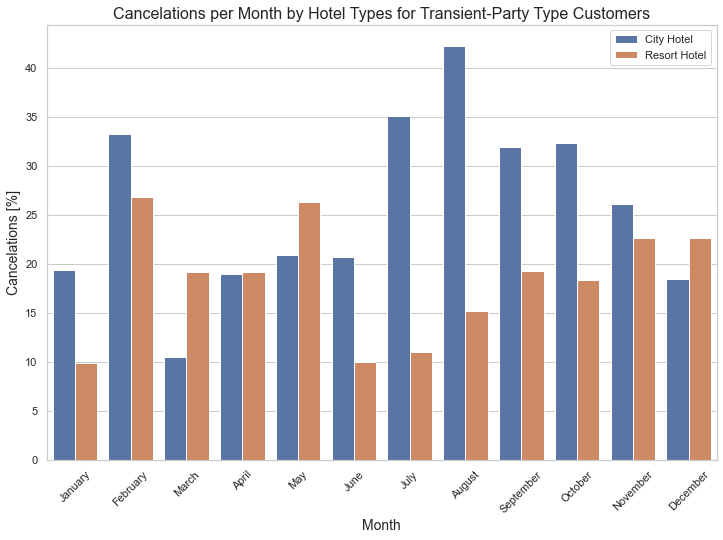

In [170]:
# bar plot of hotel bookings cancellation in each month for Transient-Party Type Customers
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "Percentage of Cancellations" , hue = "Hotel", data = cancel[cancel['Customer Type'] == 'Transient-Party'])
plt.title("Cancelations per Month by Hotel Types for Transient-Party Type Customers", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=14)
plt.legend(loc="upper right")

plt.show()

7) How many bookings did or did not get their room type

In [171]:
desired_room = df[['is_canceled', 'reserved_room_type', 'assigned_room_type', 'hotel']]

desired_room['get_desired_room_type'] = np.where(df['reserved_room_type'] == df['assigned_room_type'], 'Yes', 'No')
desired_room = desired_room.groupby(['get_desired_room_type', 'hotel'])['is_canceled'].count().reset_index()
desired_room.rename(columns = {'is_canceled' : 'Number of Bookings'}, inplace = True)

C:\Users\Haziq\AppData\Local\Temp/ipykernel_7596/1701332553.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



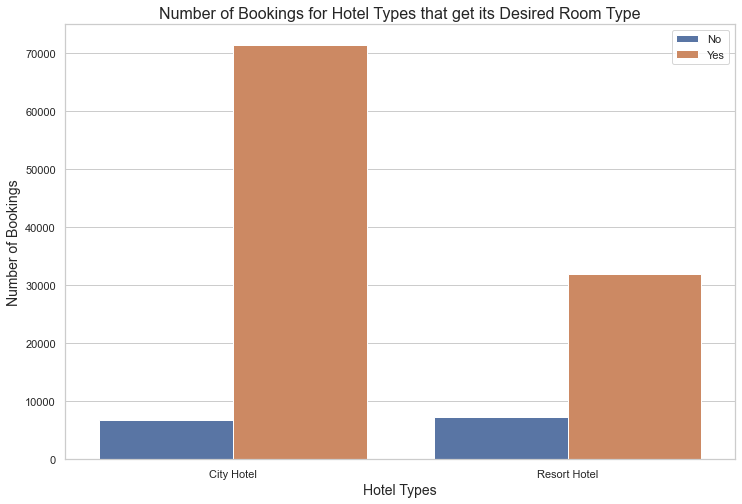

In [172]:
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "hotel", y = "Number of Bookings" , hue = "get_desired_room_type", data = desired_room)
plt.title("Number of Bookings for Hotel Types that get its Desired Room Type", fontsize=16)
plt.xlabel("Hotel Types", fontsize=14)
#plt.xticks(rotation = 45)
plt.ylabel("Number of Bookings", fontsize=14)
plt.legend(loc="upper right")

plt.show()

- Most of the hotel room reservations made at both City and Resort Hotel managed to get their desired room type, and not being assigned to other type of rooms.

8) How many guest repeat their hotel bookings each month across the year?

In [173]:
repeat = df[['arrival_date_year', 'arrival_date_month', 'hotel', 'stays_in_weekend_nights', 'is_canceled', 'is_repeated_guest', 'adults', 'children', 'babies']]
repeat['total_people'] = repeat['adults'] + repeat['children'] + repeat['babies']
repeat = repeat.groupby(['is_repeated_guest'])['total_people'].sum().reset_index()
repeat = repeat.rename(columns = {'arrival_date_month' : 'Month', 'is_repeated_guest' : 'Bookings Repeat', 'hotel' : 'Hotel', 'total_people' : 'Number of Guests Made Bookings'})
repeat['Percentage of Guests Made Bookings'] = round(repeat['Number of Guests Made Bookings'] / df.shape[0] * 100, 2)
repeat['Bookings Repeat'] = repeat['Bookings Repeat'].replace({0: 'No', 1 : 'Yes'})

C:\Users\Haziq\AppData\Local\Temp/ipykernel_7596/1082763343.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



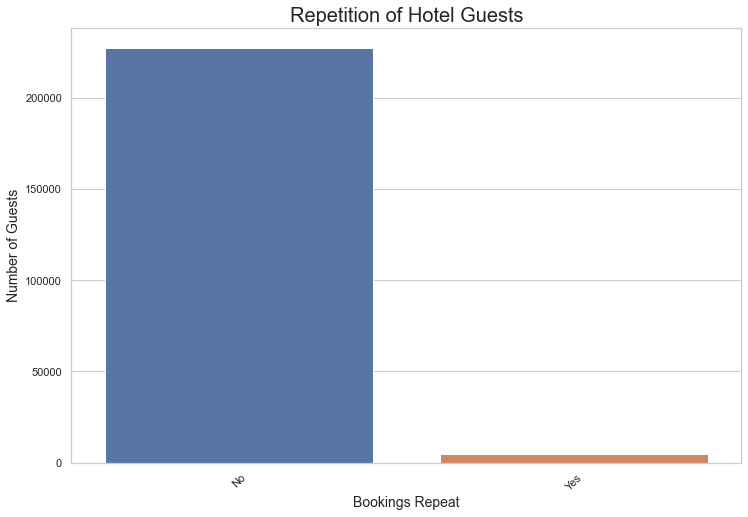

In [174]:
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Bookings Repeat", y = "Number of Guests Made Bookings" , data = repeat)
plt.title("Repetition of Hotel Guests", fontsize=20)
plt.xlabel("Bookings Repeat", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Guests", fontsize=14)
plt.show()

- Most of the bookings are considered new booking made by new hotel guest, and not coming from the same guests.
- Only less than 5% of hotel guest repeated their bookings.
- This is considered one of the important number to improve by the hotels in order to increase their revenue.

## Hotel Cancellations Prediction Model

### Feature Importance

In [175]:
def categorical_mutual_info(series):
    return mutual_info_score(series, df['is_canceled']) 

df_cat = df[categorical].apply(categorical_mutual_info) 
df_cat = df_cat.sort_values(ascending = False).to_frame(name='mutual_info_score') 
df_cat

,mutual_info_score
reservation_status,0.661491
reservation_status_date,0.134190
deposit_type,0.131699
country,0.071636
market_segment,0.036778
assigned_room_type,0.020587
distribution_channel,0.016588
customer_type,0.010188
hotel,0.009722
reserved_room_type,0.002775


In [176]:
df[numerical].corr()['is_canceled'].abs().sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.290560
total_of_special_requests         0.237361
required_car_parking_spaces       0.197507
booking_changes                   0.144594
previous_cancellations            0.110675
company                           0.083477
is_repeated_guest                 0.074568
adults                            0.056243
previous_bookings_not_canceled    0.054849
days_in_waiting_list              0.054111
agent                             0.048279
babies                            0.032478
adr                               0.030468
stays_in_week_nights              0.018941
arrival_date_year                 0.014202
arrival_date_week_number          0.009586
stays_in_weekend_nights           0.006843
arrival_date_day_of_month         0.006254
children                          0.004390
Name: is_canceled, dtype: float64

In [177]:
df.groupby('is_canceled')[numerical].mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,,,,,,,,,,,,,,,,,,,,
0,0.0,81.043222,2016.152516,27.035005,15.845590,0.941367,2.492731,1.840153,0.103176,0.010315,0.037376,0.014226,0.186717,0.286514,79.201965,14.011282,1.597814,102.383092,0.100179,0.716470
1,1.0,145.214989,2016.173245,27.303815,15.732111,0.927307,2.566683,1.896062,0.106801,0.003795,0.012021,0.208285,0.022860,0.098053,68.506556,4.776490,3.574022,105.479223,0.000000,0.328311


### Pre-Processing, Feature Engineering & Modeling

In [178]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage (i.e. arrival_date_year, country, days_in_waiting_list, booking_changes, reservation_status)
# exclude country to make the model more diverse and able to accept other hotel branches
# reservation status causes the model to overfit due to high mutual info score

num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest", 
                "previous_cancellations", "previous_bookings_not_canceled", "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [179]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, X, y, cv=split, scoring="accuracy", n_jobs=-1)
    
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DT_model cross validation accuracy score: 0.8228 +/- 0.0018 (std) min: 0.8209, max: 0.8255
RF_model cross validation accuracy score: 0.8656 +/- 0.0013 (std) min: 0.8635, max: 0.8666
LR_model cross validation accuracy score: 0.7968 +/- 0.0014 (std) min: 0.7951, max: 0.7986
XGB_model cross validation accuracy score: 0.8446 +/- 0.0009 (std) min: 0.8432, max: 0.8455


### Prediction

In [180]:
# Random Forest Classifier model is chosen to be the best model due to its high accuracy score

best_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', base_models[1][1])])
y_pred = cross_val_predict(best_model, X, y, cv=split)

#prediction output of bookings cancellation
y_pred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

## Hotel Booking Nights Prediction Model

### Preprocessing, Feature Engineering & Modeling

In [181]:
# Since there are 2 columns that indicate number of nights of hotel guest staying, we will combine them into 1 for simplicity and ease of prediction purposes
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

#features = num_features + cat_features
X = df.drop(["total_nights"], axis=1)[features]
y = df["total_nights"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [182]:
# define models to test:

base_models = [("DT_model", DecisionTreeRegressor(random_state=42)),
               ("RF_model", RandomForestRegressor(random_state=42,n_jobs=-1)),
               ("LR_model", LinearRegression(n_jobs=-1)),
               ("XGB_model", XGBRegressor(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # get cross validation score for each model:
    cv_results_mse = cross_val_score(model_steps, X, y, cv=split, scoring="neg_mean_squared_error", n_jobs=-1)
    cv_results_mae = cross_val_score(model_steps, X, y, cv=split, scoring="neg_mean_absolute_error", n_jobs=-1)
    cv_results_r2 = cross_val_score(model_steps, X, y, cv=split, scoring="r2", n_jobs=-1)
    cv_results_rmse = cross_val_score(model_steps, X, y, cv=split, scoring="neg_root_mean_squared_error", n_jobs=-1)

    # output:
    mse_score = round(np.mean(cv_results_mse), 4)
    mae_score = round(np.mean(cv_results_mae), 4)
    r2_score = round(np.mean(cv_results_r2), 4)
    rmse_score = round(np.mean(cv_results_rmse), 4)
    print(f"{name} cross validation mean squared error score: {mse_score}, mean absolute error score: {mae_score}, R2 score: {r2_score}, root mean squared error score: {rmse_score}")

DT_model cross validation mean squared error score: -0.0021, mean absolute error score: -0.0006, R2 score: 0.9997, root mean squared error score: -0.0411
RF_model cross validation mean squared error score: -0.0028, mean absolute error score: -0.0008, R2 score: 0.9996, root mean squared error score: -0.0425
LR_model cross validation mean squared error score: -0.0, mean absolute error score: -0.0, R2 score: 1.0, root mean squared error score: -0.0
XGB_model cross validation mean squared error score: -0.0018, mean absolute error score: -0.0005, R2 score: 0.9997, root mean squared error score: -0.0347


### Prediction

In [183]:
# Linear Regression model seems a bit too perfect and most likely to be overfitted. Hence, Extreme Gradient Boosting model is chosen to be the best model due to its performance i.e. MSE, MAE, R2 & RMSE

best_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', base_models[3][1])])
y_pred = cross_val_predict(best_model, X, y, cv=split)

#prediction output of booking nights at the hotel
y_pred

array([1.0000069, 1.0000111, 1.9999969, ..., 7.0000043, 7.0000043,
       9.00044  ], dtype=float32)

- There are a lot of room for improvements to improve the performance of each prediction model.
- Due to time constraint, these will be the finalized model for prediction of cancellation and period of stay for the hotel bookings
- The model can be further through detailed preprocessing, scaling certain numerical features, visualization of model performance between predicted and actual values, balancing the target variable to be 50:50 in proportion, dimensionality reduction using PCA & other methods to improve the models performance.